# NOTEBOOK TO CHECK GAIN CORRECTION ON UNALIGNED MOVIES

READ in frames from TIF movies and average.  As the frames are added they are muliplied with different GAIN images
to determine which gives the best correction.

According to this post https://groups.google.com/g/warp-em/c/-fOnQ34VMO8/m/g8d6C8T6AwAJ K2/K3 gains are multiplied to 
the raw images

In [1]:
import starfile
import mrcfile
import pandas as pd
import argparse
import os, glob, re
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tifffile # confirmed by CS-team this is same orientation as CS
import ncempy.io as nio
from ncempy.algo import rebin 

In [17]:
# input file name 
glob_file = 'Movies/*_Fractions.tiff'
n_mics = 1000                     # number of movies to average
update_freq = 20                 # update stats on the running average every x iterations
n_frames = 40
#fnGain = 'gain_sean.mrc' # in python read DM4 - > rebin wih mean -> set defect pixel to zero -> save 
fnDmGain = 'K3-18210046_GainRef.x1.m1.kv300.dm4'
#fnimodGain = 'gain_imodbin2.mrc'
#fnemanGain = 'fnDmGain = 'K3-18210046_GainRef.x1.m1.kv300.dm4''

In [18]:
# note I have no idea if ncempy flips any axis when opening... it works the same as ncempy
SRGain = nio.read(fnDmGain)
print(SRGain['data'].shape) # the shape of the data
DataGain = rebin(SRGain['data'], 2, funcType='mean')
print(DataGain.data.shape)

(8184, 11520)
(4092, 5760)


In [19]:
# read in files and modify/flip as required
# MrcGain = mrcfile.open(fnGain, mode='r+') # unmodified  gain (just bined and converted as discribed above)
# DataGain = MrcGain.data
# print (DataGain.data.shape)

DataGainflr = np.fliplr(DataGain) #  gain left right flip ( =x = flipped columns)
DataGainfud = np.flipud(DataGain) # gain up down flip ( =y = flipped rows )
DataGainrot = np.rot90(np.rot90(DataGain)) # gain rotate 180 same as both fliplr and flipud

# I dont think rot90 or rot270 are valid as the K3 sensor is rectangular and I can see that the gain  
# is in same orintation as movies



In [20]:
mic_list = glob.glob(glob_file)
print(len(mic_list))

19615


In [21]:
# MAD = median absolute deviation https://stackoverflow.com/questions/60092641/mad-results-differ-in-pandas-scipy-and-numpy
# less senstenve to outliers than std
def get_stats(a):
    m = np.mean(a)
    std = np.std(a)
    mad = np.median(np.absolute(a - np.median(a))) 
    return m, std, mad
    
# initialize zero array to accumilate running sum of frames  
# use float64. I get wrap around errors if  I use float32
# if I save to MRC remember to use .astype(np.float32)


array_none = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gain = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainflr = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainfud = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainrot = np.zeros(shape=(4092, 5760), dtype=np.float64)

# initialize zero array to store statistics every n-iterations
# ncol=12 becasue we store n_movie, n_frames, and (mean, std and mad) for each gain (= 15)
# nrow is the quotient from the number of movies diveded by the update freq
array_stats = np.zeros(shape=(n_mics // update_freq, 17)) 

for i in tqdm.tqdm(range(n_mics)):
    #print(mic_list[i])
    # print(i)
    a = tifffile.imread(mic_list[i])
    for f in range(n_frames):
        #print(i,f)
        array_none += a[f]
        array_gain += (a[f]* DataGain)
        array_gainflr += (a[f] * DataGainflr )
        array_gainfud += (a[f] * DataGainfud )
        array_gainrot += (a[f] * DataGainrot )
    if (i % update_freq == 0): # will update ever iteraction that is divible by 10 (1,11,21 movie)
        
        t = (i+1) * n_frames
        # the arrays are the running total, therefore divide by number of frames to get current average
        m_none, std_none, mad_none = get_stats(array_none / t)
        m_gain, std_gain, mad_gain = get_stats(array_gain / t)
        m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr / t)
        m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud / t)
        m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot / t)
        # strore the stats
        array_stats[int(i / update_freq)]= [i, t, m_none, std_none, mad_none, \
                         m_gain, std_gain, mad_gain, \
                         m_gainflr, std_gainflr, mad_gainflr, \
                         m_gainfud, std_gainfud, mad_gainfud, \
                         m_gainrot, std_gainrot, mad_gainrot ]


# the arrays are the running total, therefore divide by number of frames to get average
t = n_mics*n_frames
array_none /= t
array_gain /= t
array_gainflr /= t
array_gainfud /= t
array_gainrot /= t       


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:16:30<00:00, 11.79s/it]


In [22]:
print(array_stats.shape)
#print(array_stats)

(50, 17)


 NONE (m/std): 0.5907258368908341, 0.017272386711163056, 0.010824999999999974, [0.59106106 0.0173499  0.01088175]
 GAIN (m/std): 0.5952115121933337, 0.02038225684046592, 0.013048760913312474, [0.59554917 0.0204489  0.01308951]
 GAINFLR (m/std): 0.5950275827352354, 0.014002258770538794, 0.008937768603116292, [0.59536508 0.01408708 0.00898375]
 GAINFUD (m/std): 0.5952047252878956, 0.020191229834047524, 0.012912142467498777, [0.59586558 0.0203081  0.01297918]
 GAINROT (m/std): 0.5951929645915416, 0.019847505452948888, 0.012669138142466563, [0.59553047 0.01991128 0.01270702]


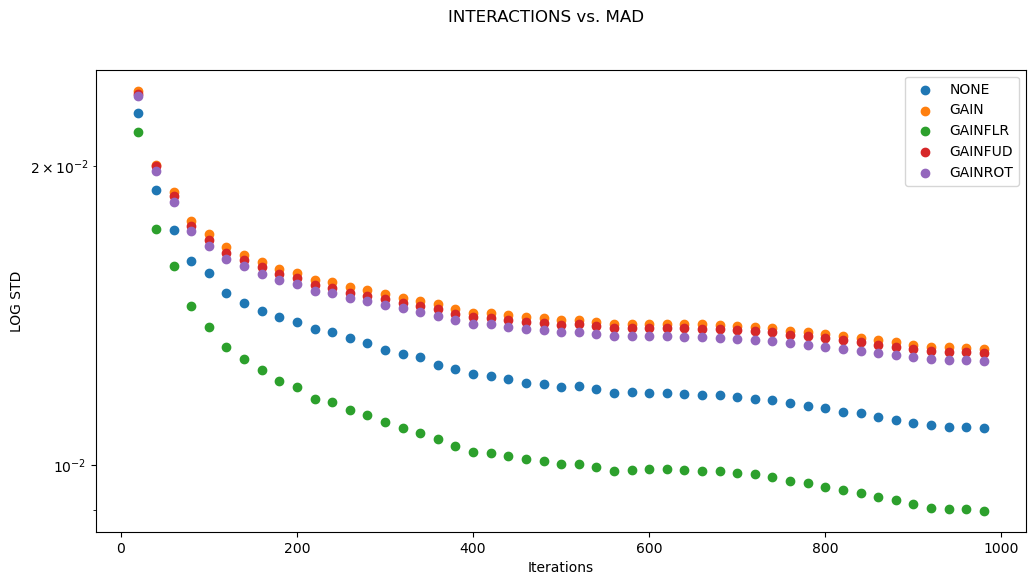

In [27]:
# print out final stats. it should be the similar as those stored in array_states but maybe not the same 
# the number of movies might not be a perfect multiple of the update freq (who is the sick freak who uses a wierd number of movies)
m_none, std_none, mad_none = get_stats(array_none )
m_gain, std_gain, mad_gain = get_stats(array_gain )
m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr )
m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud )
m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot )


print(f' NONE (m/std): {m_none}, {std_none}, {mad_none}, {array_stats[-1, 2:5]}' )
print(f' GAIN (m/std): {m_gain}, {std_gain}, {mad_gain}, {array_stats[-1, 5:8]}' )
print(f' GAINFLR (m/std): {m_gainflr}, {std_gainflr}, {mad_gainflr}, {array_stats[-1, 8:11]}' )
print(f' GAINFUD (m/std): {m_gainfud}, {std_gainfud}, {mad_gainfud}, {array_stats[-2, 11:14]}' )
print(f' GAINROT (m/std): {m_gainrot}, {std_gainrot}, {mad_gainrot}, {array_stats[-1, 14:17]}' )

fig, axs = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True,figsize=(10,5))
fig.suptitle('INTERATIONS vs. MAD')
axs.scatter(x=array_stats[1:, 0], y=array_stats[1:, 4], label='NONE')
axs.scatter(x=array_stats[1:, 0], y=array_stats[1:, 7], label='GAIN')
axs.scatter(x=array_stats[1:, 0], y=array_stats[1:, 10], label='GAINFLR')
axs.scatter(x=array_stats[1:, 0], y=array_stats[1:, 13], label='GAINFUD')
axs.scatter(x=array_stats[1:, 0], y=array_stats[1:, 16], label='GAINROT')
axs.legend(loc="upper right")
axs.set_xlabel('Iterations')
axs.set_ylabel('LOG(STD)')
axs.set_yscale("log");

Text(0.5, 1.0, 'WITH GAIN ROT180')

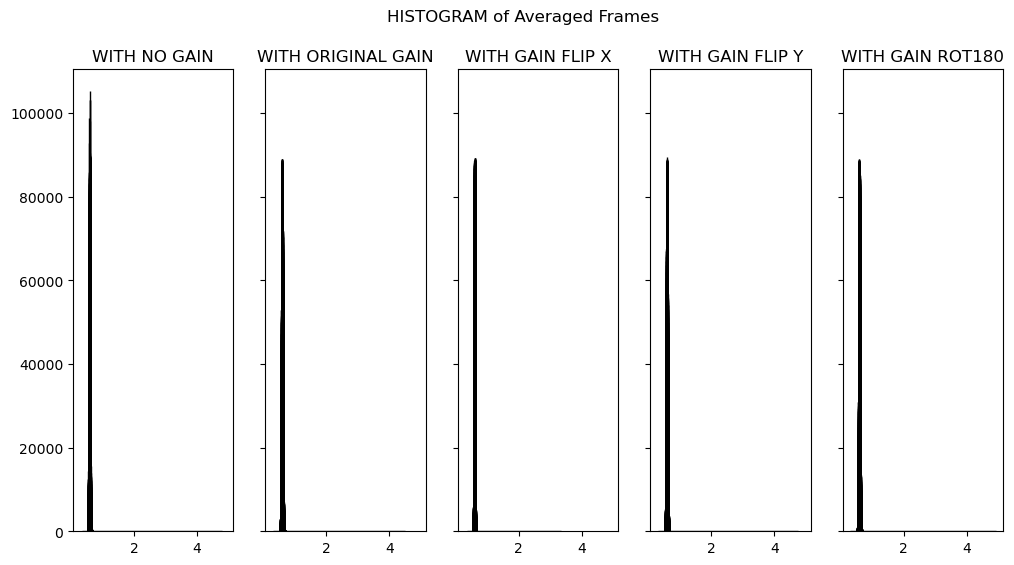

In [24]:
fig, axs = plt.subplots(1,5,sharex=True, sharey=True,figsize=(12,6))
fig.suptitle('HISTOGRAM of Averaged Frames')
axs[0].hist(array_none.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('WITH NO GAIN')
axs[1].hist(array_gain.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('WITH ORIGINAL GAIN')
axs[2].hist(array_gainflr.ravel(), bins='auto', fc='k', ec='k')
axs[2].set_title('WITH GAIN FLIP X')
axs[3].hist(array_gainfud.ravel(), bins='auto', fc='k', ec='k')
axs[3].set_title('WITH GAIN FLIP Y')
axs[4].hist(array_gainrot.ravel(), bins='auto', fc='k', ec='k')
axs[4].set_title('WITH GAIN ROT180')


Text(0.5, 1.0, 'WITH GAIN ROT180')

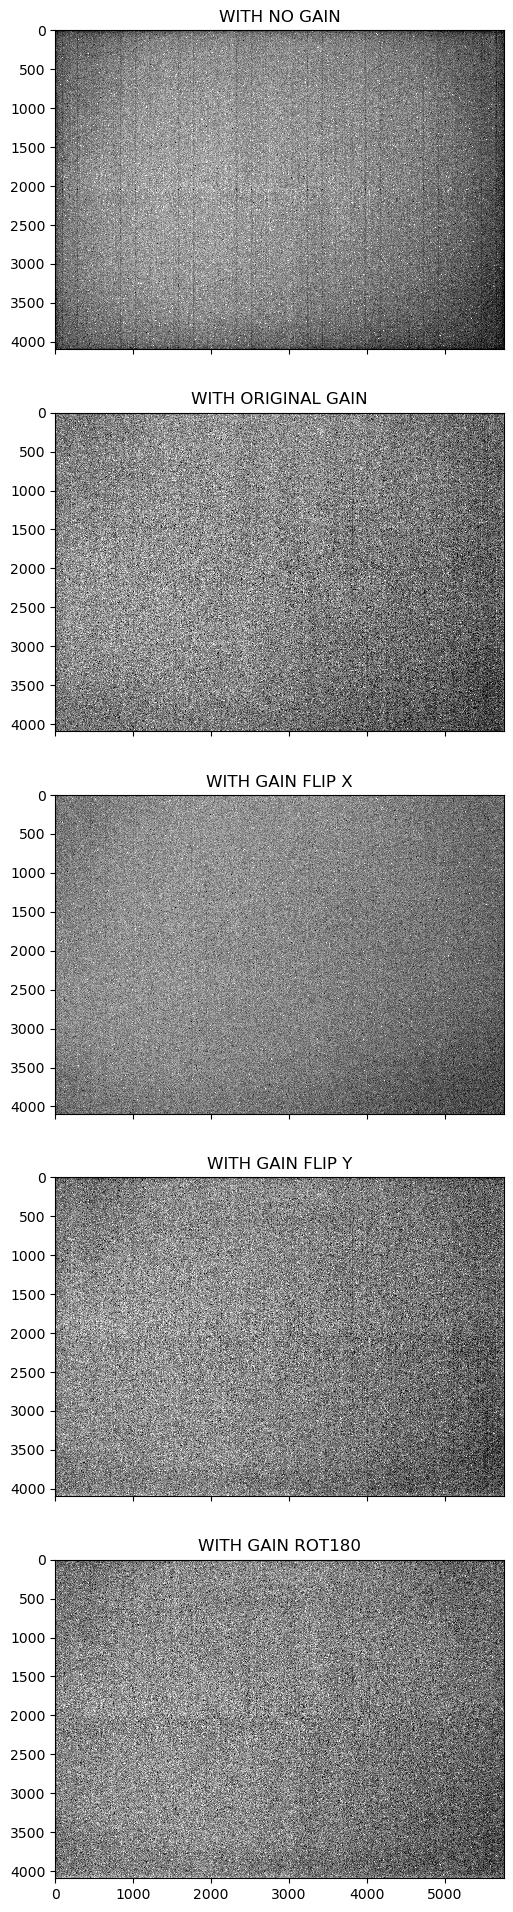

In [26]:
fig, axs = plt.subplots(nrows=5,ncols=1, sharex=True, sharey=True,figsize=(12,24))
axs[0].imshow(array_none-np.mean(array_none)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) 
axs[0].set_title('WITH NO GAIN')
axs[1].imshow(array_gain-np.mean(array_gain)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) #clim=(0.45, 0.7)
axs[1].set_title('WITH ORIGINAL GAIN')
axs[2].imshow(array_gainflr-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) #clim=(0.5, 0.7)
axs[2].set_title('WITH GAIN FLIP X')
axs[3].imshow(array_gainfud-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) #clim=(0.5, 0.7)
axs[3].set_title('WITH GAIN FLIP Y')
axs[4].imshow(array_gainrot-np.mean(array_gainrot)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) #clim=(0.5, 0.7)
axs[4].set_title('WITH GAIN ROT180')


#plt.savefig("compare_brem_relion_sean_gaincorrection.pdf", format="pdf", bbox_inches="tight")